In [2]:
import MDAnalysis as mda
from MDAnalysisData import datasets
from MDAnalysis.analysis import align
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


## Baseline1: (DCCM Dynamic Cross-Correlation Matrix)
The elements $C_{ij}$ of the cross-correlation matrix between residues $i$ and $j$ are defined as:

$$
C_{ij} = \frac{\langle \Delta \mathbf{r}_i(t) \cdot \Delta \mathbf{r}_j(t) \rangle_t}{\sqrt{\langle \Delta \mathbf{r}_i(t)^2 \rangle_t} \cdot \sqrt{\langle \Delta \mathbf{r}_j(t)^2 \rangle_t}}
$$
人话：用来衡量两个amino acid/atom有没有一起动，这是一个非常基础的physics baseline，只有correlation没有方向，也没有办法capture到时间上的滞后性，因为两个量必须一起动

In [ ]:

# ==========================================
# 1.Dataset loading
# ==========================================
print("Loading ADK DIMS data...")
adk = datasets.fetch_adk_transitions_DIMS()

# load data and use the first trajectory
u = mda.Universe(adk.topology, adk.trajectories[0])
ca = u.select_atoms("name CA")


Loading ADK DIMS data...


/home/hunter/.local/share/mamba/envs/adjoint_sampling/lib/python3.12/site-packages/MDAnalysis/coordinates/DCD.py:171: DeprecationWarning: DCDReader currently makes independent timesteps by copying self.ts while other readers update self.ts inplace. This behavior will be changed in 3.0 to be the same as other readers. Read more at https://github.com/MDAnalysis/mdanalysis/issues/3889 to learn if this change in behavior might affect you.
  warnings.warn("DCDReader currently makes independent timesteps"


In [ ]:

# ==========================================
# 2. Alignment
# ==========================================
# 我们需要把每一帧都叠合(fit)到第一帧上，消除整体的转动和平移
print("Aligning trajectory...")
ref = mda.Universe(adk.topology, adk.trajectories[0]) # 参考帧
aligner = align.AlignTraj(u, ca, select="name CA", in_memory=True).run()


Aligning trajectory...


In [ ]:

# ==========================================
# 3. calculate 3D DCCM 
# ==========================================
print("Calculating DCCM...")

# get all frames' coordinates
coords = np.array([ca.positions for ts in u.trajectory])

# calculate mean structure
mean_coords = np.mean(coords, axis=0)

# calculate deviation vectors: r_i(t) - <r_i>
# shape: (N_frames, N_residues, 3)
deviations = coords - mean_coords 

# --- 核心计算: <r_i * r_j> / sqrt(<r_i^2><r_j^2>) ---

# 分子: 协方差矩阵 (Time average of dot products)
# 使用 einsum 加速: 对时间(t)求和，对xyz坐标(k)点积
numerator = np.einsum('tik, tjk -> ij', deviations, deviations) / deviations.shape[0]

# denominator: normalize term
var = np.diagonal(numerator) # get diagonal, which is the variance of each residue
denominator = np.sqrt(np.outer(var, var))

# final matrix
dccm = numerator / denominator


Calculating DCCM...


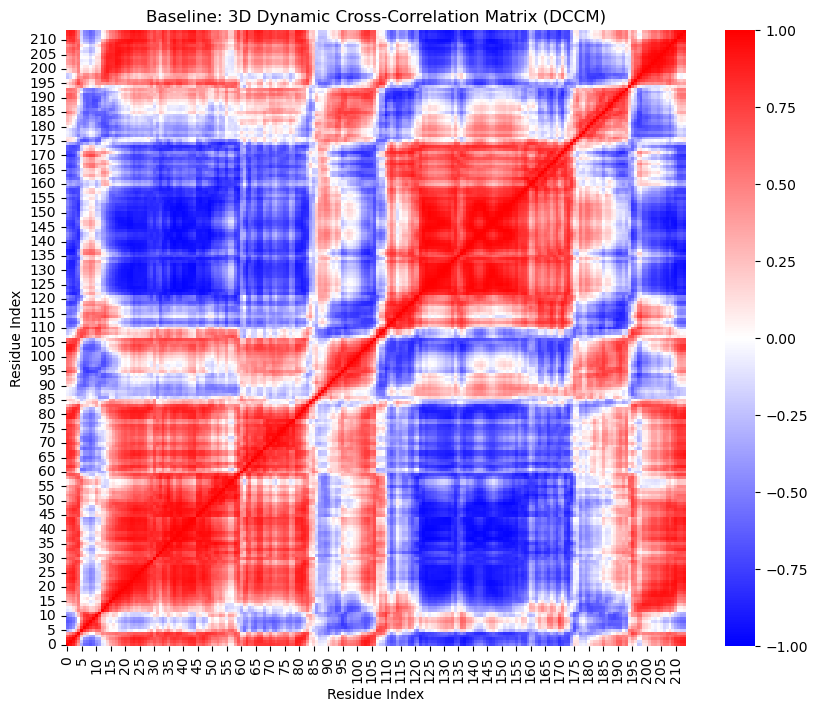

In [6]:

# ==========================================
# 4. 可视化
# ==========================================
plt.figure(figsize=(10, 8))
sns.heatmap(dccm, cmap='bwr', center=0, vmin=-1, vmax=1)
plt.title("Baseline: 3D Dynamic Cross-Correlation Matrix (DCCM)")
plt.xlabel("Residue Index")
plt.ylabel("Residue Index")
plt.gca().invert_yaxis() # 让原点在左下角，符合通常习惯
plt.show()

## Baseline2: Time-lagged Cross-Correlation Matrix (TLCC)
While DCCM measures simultaneous coupling, TLCC measures the coupling with a time delay $\tau$. The elements $C_{ij}(\tau)$ are defined as:

$$
C_{ij}(\tau) = \frac{\langle \Delta \mathbf{r}_i(t) \cdot \Delta \mathbf{r}_j(t + \tau) \rangle_t}{\sqrt{\langle \Delta \mathbf{r}_i(t)^2 \rangle_t} \cdot \sqrt{\langle \Delta \mathbf{r}_j(t+\tau)^2 \rangle_t}}
$$

Key differences from DCCM:
- **Asymmetry**: $C_{ij}(\tau) \neq C_{ji}(\tau)$.
- **Directionality**: 
  - If $C_{ij}(\tau)$ is high, correlation flows from **Residue $i$ (Past)** to **Residue $j$ (Future)**.
  - The asymmetry matrix $A_{ij} = |C_{ij}(\tau)| - |C_{ji}(\tau)|$ can effectively visualize the "net flow" direction.

  
人话：在granger和DCCM之间的一个桥梁，DCCM是对称的无向图。TLCC能产生方向性。如果残基 A 现在的运动，和残基 B 未来的运动高度相关，那么我们就可以推断：可能是 A 传导到了 B。

In [10]:
# need deviations from previous baseline(shape: N_frames, N_residues, 3)

def calc_tlcc(deviations, lag=1):
    """
    计算时滞互相关矩阵
    lag: 滞后的帧数 (integer)
    """
    n_frames = deviations.shape[0]
    if lag >= n_frames:
        raise ValueError("Lag must be smaller than total frames")
    
    # 1. 创建错位的时间窗
    # data_t: 0 到 N-lag (代表过去)
    data_t = deviations[:-lag] 
    # data_tau: lag 到 N (代表未来)
    data_tau = deviations[lag:] 
    
    # 2. numerator
    # 这里的点积是: r_i(t) dot r_j(t + lag)
    # shape: (N_res, N_res)
    numerator = np.einsum('tik, tjk -> ij', data_t, data_tau) / data_t.shape[0]
    
    # 3. denominator (Normalization)
    var_t = np.einsum('tik, tik -> i', data_t, data_t) / data_t.shape[0]
    var_tau = np.einsum('tjk, tjk -> j', data_tau, data_tau) / data_tau.shape[0]
    denominator = np.sqrt(np.outer(var_t, var_tau))
    
    # 4. TLCC
    # 防止分母为0
    denominator[denominator == 0] = 1e-10
    
    tlcc = numerator / denominator
    return tlcc

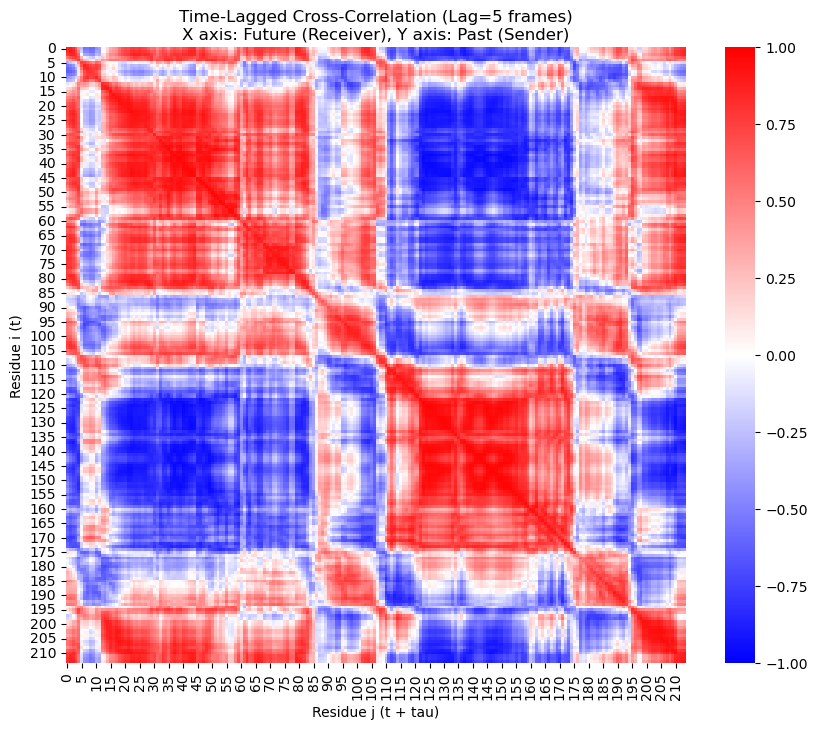

In [11]:

# ===============================
# analysis
# ===============================

# 设定滞后时间 (Lag)
# e.g.: 10 frames。如果在 DIMS 数据集中，这代表一段明显的构象变化时间。
tau = 5 
tlcc_matrix = calc_tlcc(deviations, lag=tau)

# ===============================
# visualization 1: TLCC 矩阵本身
# ===============================
plt.figure(figsize=(10, 8))
sns.heatmap(tlcc_matrix, cmap='bwr', center=0, vmin=-1, vmax=1)
plt.title(f"Time-Lagged Cross-Correlation (Lag={tau} frames)\nX axis: Future (Receiver), Y axis: Past (Sender)")
plt.xlabel("Residue j (t + tau)")
plt.ylabel("Residue i (t)")
plt.show()


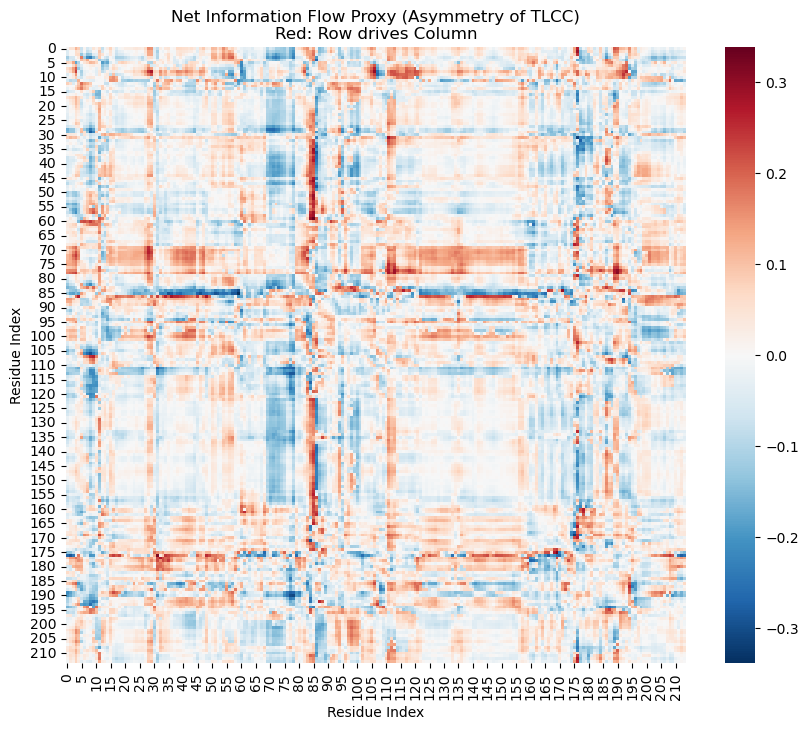

In [12]:

# ===============================
# visualization 2: 净流量图 (Net Flow) !!
# ===============================
# 如果 C_ij > C_ji，说明 i 对 j 的影响 > j 对 i 的影响
# 我们计算不对称部分
net_flow = np.abs(tlcc_matrix) - np.abs(tlcc_matrix.T)

plt.figure(figsize=(10, 8))
sns.heatmap(net_flow, cmap='RdBu_r', center=0) # Red = i drives j, Blue = j drives i
plt.title(f"Net Information Flow Proxy (Asymmetry of TLCC)\nRed: Row drives Column")
plt.xlabel("Residue Index")
plt.ylabel("Residue Index")
plt.show()

I cannot see a jack shit of info from the plot above, which is good. and we can improve I guess?